# Nội dung thực hành:


- Hiểu được cách xây dựng CSDL phi cấu trúc gồm cả ảnh và text theo cấu trúc data Warehouse. Thực hành truy vấn dữ liệu gồm 1 triệu ảnh trên MongoDB và thực hiện một số phép tính cơ bản.
- Thực hành thiết lập local MongoDB database server.
- Xây dựng CSDL MongoDB & Đọc dữ liệu từ jupyter notebook và phân tích dữ liệu với pandas.
- Đọc dữ liệu từ API theo cấu trúc JSON.
- Lọc dữ liệu và tính toán khoảng cách với hàm Haversine Distance Calculation.
- Vẽ đồ thị từ dữ liệu truy vấn với Matplotlib và NumPy.
- Xây dựng hàm hồi quy tuyến tính với SciPy.

Tài liệu tham khảo:

- https://thedatafrog.com/en/articles/mongodb-python-pandas/
- https://www.openlayer.com/blog/post/10-examples-of-using-python-for-big-data-analysis (phải điều chỉnh lại theo CSDL MongoDB)


# Xây dựng 1 NoSQL database theo kiến trúc Data warehouse & Truy vấn trên 1.000.000 ảnh

Do 1.000.000 ảnh là con số lớn có thể làm quá tải hệ thống phần cứng tôi có, mặt khác do đang có sẵn gần 5000 ảnh được cắt ra các vùng quan tâm từ hơn 1000 ảnh sinh thiết ung thư tuyến giáp nên tôi sẽ nạp gần 5000 ảnh lên MongoDB cho tương xứng với yêu cầu thực hành.  

In [18]:
import os, time, base64, io 
from pymongo import MongoClient
from PIL import Image

# Kết nối đến MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["image_database"]  # Chọn hoặc tạo một cơ sở dữ liệu MongoDB
collection = db["images"]  # Chọn hoặc tạo một bộ sưu tập trong cơ sở dữ liệu

# Đường dẫn đến thư mục chứa ảnh
folder_path = "/mnt/DataK/Project/ThyroidCancer/data/processed_data/patch_level/run"

# Đếm và in ra số lượng ảnh sẽ tải lên
uploaded_images = len(os.listdir(folder_path))
print("Số lượng ảnh sẽ tải lên:", uploaded_images)

# Lặp qua tất cả các tệp trong thư mục
for filename in os.listdir(folder_path):
    if filename.endswith((".jpg", ".jpeg", ".png")):  # Chỉ xử lý các tệp ảnh
        image_path = os.path.join(folder_path, filename)
        with open(image_path, "rb") as img_file:
            # Đọc dữ liệu ảnh và mã hóa thành Base64
            image_data = base64.b64encode(img_file.read()).decode("utf-8")

        # Tạo một tài liệu mới trong MongoDB
        document = {
            "label": filename[:2],
            "image_data": image_data,
            "upload_time": time.time(),
        }

        # Chèn tài liệu vào bộ sưu tập
        collection.insert_one(document)

# Kiểm tra số lượng bản ghi trong MongoDB
mongodb_records = collection.count_documents({})
print("Số lượng bản ghi trong MongoDB:", mongodb_records)

print(f"Đã nạp toàn bộ {mongodb_records} ảnh vào MongoDB.") # Cái này tôi lỡ chạy lại 2 lần thế là đang có gần 15000 bản ghi - thiệt hại máy quá đi tý lại phải xóa 

Số lượng ảnh sẽ tải lên: 4942
Số lượng bản ghi trong MongoDB: 14826
Đã nạp toàn bộ 14826 ảnh vào MongoDB.


Sau đây tôi sẽ thực hiện truy vấn lấy ra các bản ghi có label là `B2`, và do tính chất bảo mật dữ liệu cũng như để bài báo cáo này không "dài 5000 trang" thì tôi sẽ vẽ ra 16 kết quả đầu tiên thôi.

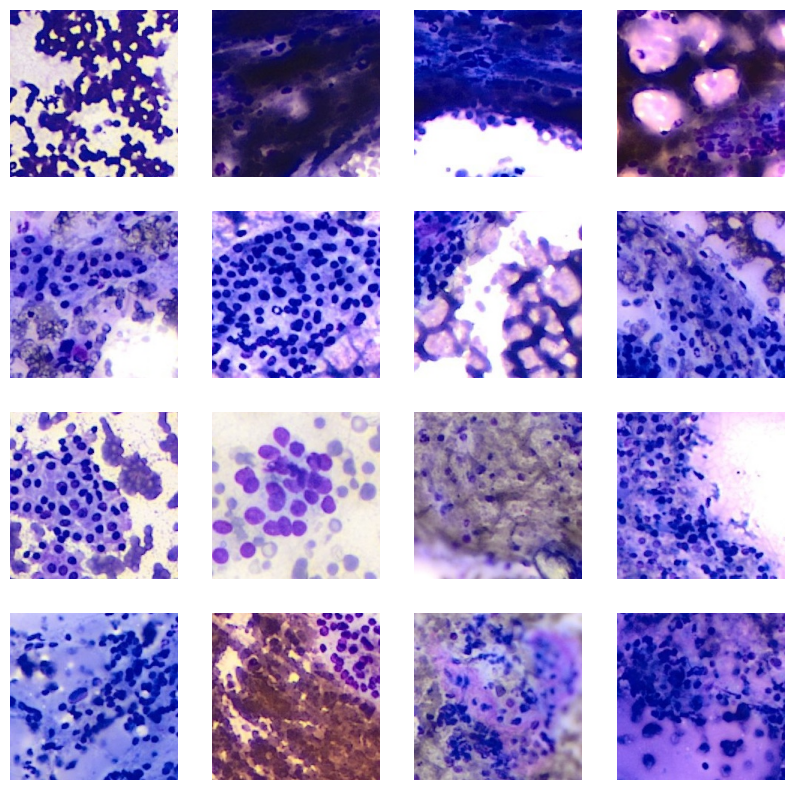

In [19]:
import matplotlib.pyplot as plt
import io

# Thực hiện truy vấn với label = 'B2' với label = filename[:2]
query1 = collection.find({'label': 'B2'})
# query1 = collection.find({'label': {'$regex': '^.{2}$'}})  # filename[:2]

# Lấy 16 ảnh đầu tiên từ kết quả truy vấn
images = []
for query in [query1,]:
    for document in query.limit(16):
        images.append(document['image_data'])

# Hiển thị trực quan hóa cho 16 ảnh đầu tiên
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, image_data in enumerate(images):
    row = i // 4
    col = i % 4
    img_data = base64.b64decode(image_data)
    img = Image.open(io.BytesIO(img_data))
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
plt.show()

Sau đây tôi sẽ xóa cơ sở dữ liệu vừa tạo đi để giải phóng bộ nhớ

In [20]:
print(client.list_database_names())

['admin', 'big_data', 'config', 'image_database', 'local', 'test']


In [24]:
client.drop_database('image_database')
client.drop_database('big_data')    # cái này là cơ sở dữ liệu tôi tạo cho ví dụ bên dưới
print(client.list_database_names()) # tuyệt vời giờ mongodb đã sạch sẽ

['admin', 'config', 'local', 'test']


# Set up a local MongoDB database server


Tham khảo phần **Set up a local MongoDB database server** tại đây theo hướng dẫn: https://thedatafrog.com/en/articles/mongodb-python-pandas/  
(tuy nhiên không làm theo vì nó không hướng dẫn cho nền tảng OS đang dùng - kể cả trong document được linking đến MongoDB document)

Ngoài ra có thể tham khảo thêm về **Cách thiết lập để App Server kết nối đến MongoDb Server** mà cá nhân tôi thấy có thể hay tại: https://blog.duyet.net/2015/04/mongodb-cach-thiet-lap-e-app-server-ket.html

Nếu còn thấy khó hiểu về các **kiến thức truy vấn cơ bản với MongoDB** thì tôi thấy 2 trang sau khá hay: https://viblo.asia/p/mongodb-p3-huong-dan-cai-dat-va-su-dung-mongodb-Ny0VGdwY4PA và MongoDB document


Sau đây ta sử dụng yay - 1 trình quản lý gói cái đặt - trên Arch Linux hoặc các OS base on Arch Linux.


In [6]:
!yay -S mongodb-bin

AUR Explicit (1): mongodb-bin-7.0.7-1
:: PKGBUILD up to date, skipping download: mongodb-bin
  1 mongodb-bin                      (Installed) (Build Files Exist)
==> Packages to cleanBuild?
==> [N]one [A]ll [Ab]ort [I]nstalled [No]tInstalled or (1 2 3, 1-3, ^4)
==> ^C


In [7]:
!mongod --version

db version v7.0.6
Build Info: {
    "version": "7.0.6",
    "gitVersion": "66cdc1f28172cb33ff68263050d73d4ade73b9a4",
    "openSSLVersion": "OpenSSL 1.1.1w  11 Sep 2023",
    "modules": [],
    "allocator": "tcmalloc",
    "environment": {
        "distmod": "ubuntu2004",
        "distarch": "x86_64",
        "target_arch": "x86_64"
    }
}


Tùy chọn khởi động mongodb bằng shell


In [ ]:
# !sudo systemctl start mongodb
# !sudo systemctl status mongodb
# !systemctl enable mongodb

# Create a database & fill it with data. Read this data from a jupyter notebook for analysis with pandas


## Khởi tạo và chèn dữ liệu vào database của mongodb


Phần nội dung này được thầy nghĩ ra tham khảo theo cấu trúc của bài viết: https://thedatafrog.com/en/articles/mongodb-python-pandas/


Khởi động bằng command shell:  
Thông thường như hướng dẫn những cái khác là `mongo`  
Tuy nhiên để chạy trên Arch ta dùng `mongosh`


In [9]:
# !mongosh

Mọi người có thể nghiên cứu cách dùng mongo shell sau. Hiện tại dùng % không được cho lệnh mongosh (chỉ được !mongosh) nên dưới đây tôi dùng Python.


Cài đặt thư viện Python cần thiết để chương trình Python giao tiếp được với Mongo


In [3]:
!pip install pymongo 

Dưới đây là ví dụ chèn 100 document {text} vào collection sin_data của database big_data


In [4]:
import pymongo
import math

# define the client, the database, and the collection
# the database and the collection are created at first insert
# if needed
client = pymongo.MongoClient("localhost", 27017)
mydb = client["big_data"]
sinfun = mydb["sin_data"]

print("insert")
data = []
for i in range(100):
    x = i / 10.0
    y = math.sin(x)
    data.append({"x": x, "y": y})
# the list of records is written to the database in one go:
sinfun.insert_many(data)
print("done")

insert
done


Xem thông tin đã nạp vào


In [5]:
import pandas as pd

cursor = sinfun.find()
entries = list(cursor)
entries[:5]

[{'_id': ObjectId('65fa81aff7b8928af7df4f22'), 'x': 0.0, 'y': 0.0},
 {'_id': ObjectId('65fa81aff7b8928af7df4f23'),
  'x': 0.1,
  'y': 0.09983341664682815},
 {'_id': ObjectId('65fa81aff7b8928af7df4f24'),
  'x': 0.2,
  'y': 0.19866933079506122},
 {'_id': ObjectId('65fa81aff7b8928af7df4f25'),
  'x': 0.3,
  'y': 0.29552020666133955},
 {'_id': ObjectId('65fa81aff7b8928af7df4f26'),
  'x': 0.4,
  'y': 0.3894183423086505}]

## Sử dụng Pandas để phân tích dữ liệu đọc bằng Jupyter Notebook


In [6]:
df = pd.DataFrame(entries)
df.head()

,_id,x,y
0,65fa81aff7b8928af7df4f22,0.0,0.000000
1,65fa81aff7b8928af7df4f23,0.1,0.099833
2,65fa81aff7b8928af7df4f24,0.2,0.198669
3,65fa81aff7b8928af7df4f25,0.3,0.295520
4,65fa81aff7b8928af7df4f26,0.4,0.389418


Vẽ 100 dữ liệu đã nạp vào MongoDB để minh họa


<Axes: xlabel='x'>

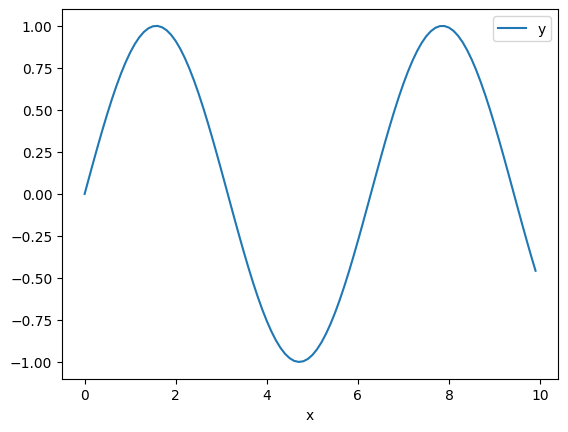

In [7]:
df.plot("x")

# Reading Data with Pandas (Bonus read from JSON result after a API request)


Phần nội dung này được thầy nghĩ ra tham khảo theo cấu trúc của bài viết: https://www.openlayer.com/blog/post/10-examples-of-using-python-for-big-data-analysis  
(Theo bố cục bài viết thì là Example 1)


## Dùng pandas đọc data từ 1 file csv


In [ ]:
# import pandas library abbreviated as pd
import pandas as pd

# create variable to hold dataframe called df and read the csv file into it
df = pd.read_csv("file_name.csv")  # set file_name.csv cho phù hợp

# print result to the screen
print(df)

Do đọc file csv không là trọng tâm nội dung thực hành buổi này nên tôi sẽ viết qua cấu trúc bên trên và không thực hiện với dữ liệu thật tôi có.


## Đọc JSON từ kết quả trả về của 1 API request


In [1]:
import requests

APIKey = "cb852dbccf56cbfb688b8c03627c6205"
# city = input("Nhập tên thành phố: ")
city = "Hanoi"

if city == "":
    exit()

response = requests.get(
    f"https://api.openweathermap.org/data/2.5/weather?q={city}&units=metric&appid={APIKey}"
)

if response.status_code == 200:
    data = response.json()
    print("Dữ liệu JSON từ API:")
    print(data)
else:
    print("Không thể truy cập API.")

Dữ liệu JSON từ API:
{'coord': {'lon': 105.8412, 'lat': 21.0245}, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 22, 'feels_like': 21.85, 'temp_min': 22, 'temp_max': 22, 'pressure': 1020, 'humidity': 61, 'sea_level': 1020, 'grnd_level': 1019}, 'visibility': 10000, 'wind': {'speed': 1.45, 'deg': 45, 'gust': 2.68}, 'clouds': {'all': 100}, 'dt': 1710922622, 'sys': {'type': 1, 'id': 9308, 'country': 'VN', 'sunrise': 1710889241, 'sunset': 1710932849}, 'timezone': 25200, 'id': 1581130, 'name': 'Hanoi', 'cod': 200}


Dưới đây ta rút ra các thông tin quan trọng từ JSON trả về từ API


In [2]:
data = response.json()
# Trích xuất các thông tin quan trọng từ dữ liệu JSON
city_name = data["name"]
country = data["sys"]["country"]
weather_description = data["weather"][0]["description"]
temperature = data["main"]["temp"]
feels_like = data["main"]["feels_like"]
humidity = data["main"]["humidity"]
wind_speed = data["wind"]["speed"]

# In các thông tin đã trích xuất
print("Tên thành phố:", city_name)
print("Quốc gia:", country)
print("Mô tả thời tiết:", weather_description)
print("Nhiệt độ hiện tại:", temperature, "°C")
print("Nhiệt độ cảm nhận:", feels_like, "°C")
print("Độ ẩm:", humidity, "%")
print("Tốc độ gió:", wind_speed, "m/s")

Tên thành phố: Hanoi
Quốc gia: VN
Mô tả thời tiết: overcast clouds
Nhiệt độ hiện tại: 22 °C
Nhiệt độ cảm nhận: 21.85 °C
Độ ẩm: 61 %
Tốc độ gió: 1.45 m/s


# Filtering Data with pandas & NumPy Library for Math Functions and Setting Data Dimensions & Using NumPy Math Functions to Create a Haversine Distance Calculation


## Sử dụng Pandas Filter the data


Có thể sử dụng Pandas để thực hiện các truy vấn SQL như kiểu:

```sql
SELECT *
FROM table
WHERE column_name = some_value
```


Trở thành tương ứng với Pandas là:

```python
df.loc[df['column_name'] == some_value]
```


## Sử dụng NumPy cho các hàm toán học và đặt các chiều data


Thư viện NumPy và math của Python có nhiều hàm trùng lặp nhau, tuy nhiên có điểm khác biệt cơ bản là:

- NumPy liên tục được tối ưu để hoạt động tốt trên kiến trúc CPU mới nhất
- Mảng trong NumPy được tối ưu lưu trữ hơn 15 lần so với sử dụng `list` của Python

=> NumPy được sử dụng trong các dự án Python khoa học dữ liệu - khi mà tốc độ và tài nguyên là quan trọng


## Sử dụng các hàm tính toán trong NumPy để tạo 1 Haversine Distance Calculation


In [3]:
import numpy as np


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Para:
        lat1, lon1: 2 tọa độ của điểm A
        lat2, lon2: 2 tọa độ của điểm B
    Return:
        Hàm này sẽ trả về khoảng cách theo độ đo Haversine giữa 2 điểm A và B trong không gian 2 chiều
    Thông tin thêm:
        Khoảng cách Haversine là một phương pháp tính toán khoảng cách giữa hai điểm trên một hình cầu, như trái đất, khi biết tọa độ (vĩ độ và kinh độ) của chúng.
        Phương pháp này được sử dụng rộng rãi trong địa lý học và định vị GPS.
    """
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = (
        np.sin(delta_phi / 2) ** 2
        + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    )
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)


LondonLongitude = -0.118092
LondonLatitude = 51.509865
ParisLongitude = 2.349014
ParisLatitude = 48.864716


print(
    "Khoảng cách theo độ đo Haversine của London và Paris là",
    haversine_distance(LondonLatitude, LondonLongitude, ParisLatitude, ParisLongitude),
)

Khoảng cách theo độ đo Haversine của London và Paris là 342.54


# Trực quan hóa dữ liệu truy vấn bằng cách sử dụng phối hợp Matplotlib và NumPy


## Using Matplotlib to Create a Scatter and Bar Graph


    name  age gender       state  num_children  num_pets
0   john   23      M  california             2         5
1   mary   78      F          dc             0         1
2  peter   22      M  california             0         0
3   jeff   19      M          dc             3         5
4   bill   45      M  california             2         2
5   lisa   33      F       texas             1         2
6   jose   20      M       texas             4         3


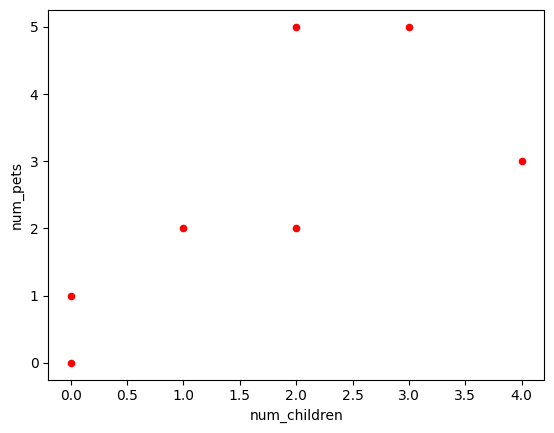

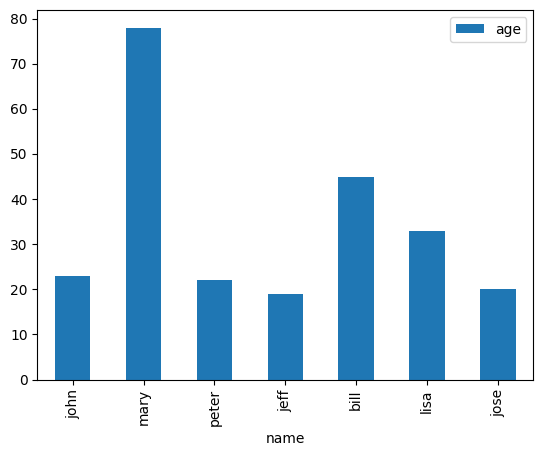

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(
    {
        "name": ["john", "mary", "peter", "jeff", "bill", "lisa", "jose"],
        "age": [23, 78, 22, 19, 45, 33, 20],
        "gender": ["M", "F", "M", "M", "M", "F", "M"],
        "state": [
            "california",
            "dc",
            "california",
            "dc",
            "california",
            "texas",
            "texas",
        ],
        "num_children": [2, 0, 0, 3, 2, 1, 4],
        "num_pets": [5, 1, 0, 5, 2, 2, 3],
    }
)

print(df)

# a scatter plot comparing num_children and num_pets
df.plot(kind="scatter", x="num_children", y="num_pets", color="red")
plt.show()

# a simple bar plot showing the name and age of child
df.plot(kind="bar", x="name", y="age")
plt.show()

## Using Matplotlib to Import Image Data as a NumPy Array


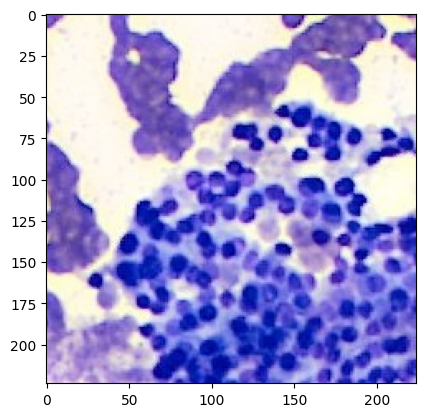

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(
    "/mnt/DataK/Project/ThyroidCancer/data/processed_data/patch_level/run/B2_3_z4975994048844_78344d064261aea4a19f453d6f4d7a93.jpg"
)
imgplot = plt.imshow(img)
plt.show()

Ngoài ra có thể thực hiện slice 1 ảnh và chuyển các giá trị màu về nằm trong [0, 1].  
Như ví dụ code dưới đây ta lấy 1 ảnh mới slice qua toàn bộ các pixel của ảnh cũ và giá trị màu từ [0, 255] về còn thuộc [0, 1]


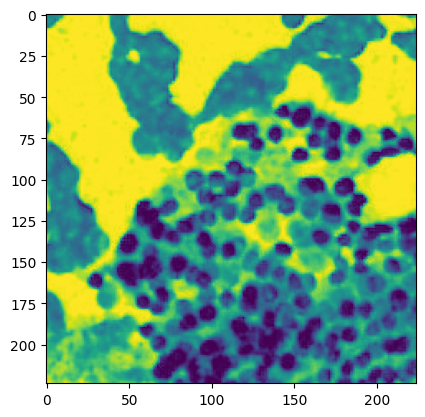

In [6]:
lum_img = img[:, :, 0]
plt.imshow(lum_img)

## Using Plotly to Plot a Line on a Map from London to Paris


Plotly là công cụ tuyệt vời cho các dự án dữ liệu lớn liên quan đến trực quan hóa dữ liệu bản đồ.  
Dưới đây là code trực quan hóa đường cong (trong không gian 3D) thành đường thẳng 2D khi chiếu bề mặt Trái Đất lên mặt phẳng kinh độ, vĩ độ (chi tiết xem lại code tính khoảng cách Haversine ở phía trên)


In [8]:
import plotly.graph_objects as go

LondonLongitude = -0.118092
LondonLatitude = 51.509865
ParisLongitude = 2.349014
ParisLatitude = 48.864716

fig = go.Figure(
    go.Scattermapbox(
        mode="markers+lines",
        lon=[LondonLongitude, ParisLongitude],
        lat=[LondonLatitude, ParisLatitude],
        marker={"size": 10},
    )
)
fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    mapbox={
        "center": {"lon": LondonLongitude, "lat": LondonLatitude},
        "style": "stamen-terrain",
        "center": {"lon": ParisLongitude, "lat": ParisLatitude},
        "zoom": 5,
    },
)
fig.show()

# SciPy Library for Regression and Hypothesis Testing


## Using SciPy to Make Linear Predictions


Sử dụng **hồi quy tuyến tính để dự đoán** tốc độ của 1 `xe cũ tồi tàn 10 năm tuổi` rồi :-)


In [13]:
# Predict the speed of a 10 years old car:
from scipy import stats

x = [5, 7, 8, 7, 2, 17, 2, 9, 4, 11, 12, 9, 6]
y = [99, 86, 87, 88, 111, 86, 103, 87, 94, 78, 77, 85, 86]

slope, intercept, r, p, std_err = stats.linregress(x, y)


def myfunc(x):
    return slope * x + intercept


year_old = 10
speed = myfunc(year_old)

print(f"Tốc độ dự đoán của xe có {year_old} tuổi là {speed} km/h")
print(
    "Thông tin về mô hình tuyến tính thu được {slope, intercept, r, p, std_err}:",
    slope,
    intercept,
    r,
    p,
    std_err,
    sep="\n",
)

Tốc độ dự đoán của xe có 10 tuổi là 85.59308314937454 km/h
Thông tin về mô hình tuyến tính thu được {slope, intercept, r, p, std_err}:
-1.7512877115526118
103.10596026490066
-0.758591524376155
0.0026468739224561064
0.453536157607742


## Using scikit-learn to Make Predictions

Nếu ví dụ bên trên dự đoán nhờ 1 mô hình hồi quy tuyến tính thì ở ví dụ này chúng ta sẽ sử dụng phân cụm KMean để xác định 1 bánh với 3 tham số (lượng đường, lượng lúa mỳ, lượng trứng) được sử dụng sẽ cho vào là loại đồ ăn gì (cake hay bread).  

In [14]:
from sklearn.utils import Bunch
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

example_foods = Bunch(
    data=np.array(
        [
            [335, 265, 4],
            [200, 200, 4],
            [225, 225, 4],
            [300, 300, 4],
            [4, 300, 0],
            [6, 500, 0],
            [0, 750, 0],
            [0, 500, 0],
        ]
    ),
    target=np.array(
        ["cake", "cake", "cake", "cake", "bread", "bread", "bread", "bread"]
    ),
)
kmeans = KMeans(
    n_clusters=2
)  # with KMeans you get to pre specify the number of Clusters
KModel = kmeans.fit(
    example_foods.data
)  # fit a model using the training data , in this case original example food data passed through

crosstab = pd.crosstab(example_foods.target, KModel.labels_)
print("Let's see how good machine learning is at separating bread and cake recipes")
print()
print(crosstab)
print()
print(
    "Most of the time it gets it right.\n\nWould you like to test?\n\nFind a cake or bread recipe and put in the gram measurements and egg count"
)
sugar = int(input("How many grams of sugar?\t"))
flour = int(input("How many grams of flour?\t"))
eggs = int(input("How many eggs?\t"))
newvals = np.array([[sugar, flour, eggs]])
predictions = kmeans.predict(newvals)
predictions = str(predictions)
predictions = predictions.replace("0", "cake")
predictions = predictions.replace("1", "bread")
predictions = predictions[1:-1]
print(predictions)

Let's see how good machine learning is at separating bread and cake recipes

col_0  0  1
row_0      
bread  1  3
cake   4  0

Most of the time it gets it right.

Would you like to test?

Find a cake or bread recipe and put in the gram measurements and egg count
bread
